Sketching outline of "lite" lensing likelihood wrapper for Cobaya

In [1]:
from lensing_lite import LensingLiteLikelihood

lensing_like = LensingLiteLikelihood()

info = {'likelihood': {'lensing_lite': lensing_like},
        
         'params': {'A_s': 2.215e-9,
#                     'A_s': {'value': 'lambda A_s: np.log10(10**10 * A_s)',
#                              'derived': False,
#                              'prior': {'min': 1.7, 'max': 3.9},
#                                      'ref' : {'dist': 'norm', 
#                                               'loc' : 3.098,
#                                               'scale': 0.001},
#                                      'proposal': 0.001,
#                                      'latex': '\\log(10^{10} A_\\mathrm{s})'},
#                     'n_s': 0.965,
#                     'theta_s_1e2': 1.0416,
#                     'omega_b': 0.0224,
                    'omega_cdm': 0.12,
#                     'tau_reio': 0.055,
                   },
         'sampler': {'mcmc': {'covmat': 'auto', 'drag': True, 'proposal_scale': 1.9}},
         'theory': {'classy': 
                       {'extra_args': 
                           {'non linear': 'halofit',
                            'N_ncdm': 1,
                            'N_ur': 2.0328,
                            'output': 'pCl'}}
                   }
       }
        

In [2]:
from cobaya.model import get_model
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[lensing_lite] Initialised external likelihood.
[classy] Importing *global* CLASS.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['Cl']


In [3]:
model.loglike({}, cached=False)

(-701.7601052506207, [])

In [41]:
model.likelihood.theory.translate_param??

Signature: model.likelihood.theory.translate_param(p, force=False)
Docstring: <no docstring>
Source:   
    def translate_param(self, p, force=False):
        # "force=True" is used when communicating with likelihoods, which speak "planck"
        if self.use_planck_names or force:
            return self.planck_to_classy.get(p, p)
        return p
File:      ~/miniconda3/envs/cobaya/lib/python3.7/site-packages/cobaya/theories/classy/classy.py
Type:      method


In [6]:
%timeit model.loglike({}, cached=False)

1.27 s ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
import numpy as np
theory_kk = np.array("""
1.27282502e-07 7.33706920e-08 4.53883593e-08 3.11615262e-08
 2.25779046e-08 1.69828218e-08 1.32097183e-08 1.05788888e-08
 8.65520010e-09 7.17852544e-09 6.02188421e-09 5.10375090e-09
 4.36380512e-09 3.76014484e-09 3.25828374e-09 2.83485997e-09
 2.47557638e-09 2.16873855e-09 1.90511922e-09 1.67738411e-09
 1.47925419e-09 1.30598938e-09 1.15406405e-09 1.03225449e-09""".split()).astype(float)

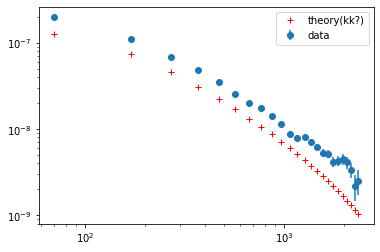

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.errorbar(lensing_like.ell, lensing_like.bandpowers, 
             np.sqrt(lensing_like.cov.diagonal()), marker='o', ls='none', label='data')
plt.xscale('log')
plt.yscale('log')

plt.loglog(lensing_like.ell, theory_kk, marker='+', ls='none', color='r', label='theory(kk?)')
plt.legend()